In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import time
from tqdm import tqdm, trange
import os
import sys
from make_waveform import BatchedLightSimulation

sys.path.append('/sdf/home/c/carsmith/flash_reconstruction/siren-lartpc')
sys.path.append('..')

### First, instantiate the simulator. Also includes waveform generation functionality.
Parameters:
* `wf_length`: Target length of waveforms, in nanoseconds
* `downsample_factor`: Simulation resolution, expressed as "# simulation ticks per ns tick". Default value is 10, i.e. simulating at 100 picosecond resolution. Will be downsampled back to 1 ns ticks.
* `offset`: Sometimes helpful - offsets all waveforms generated by this amount from 0 ns

In [2]:
device = torch.device('cuda:0')
sim = BatchedLightSimulation(cfg="templates/waveform_sim.yaml", wf_length=8000, downsample_factor=10, offset=2560).to(device)

BatchedLightSimulation Config:
	SINGLET_FRACTION: uniform(0.1, 0.5)
	LIGHT_OSCILLATION_PERIOD: uniform(0.05, 0.20)
	LIGHT_RESPONSE_TIME: uniform(0.01, 0.10)
	LIGHT_GAIN: uniform(-50.0, -20.0)
	TAU_S: uniform(0.0001, 0.01)
	TAU_T: uniform(0.9, 2.1)
	
	NOMINAL_SINGLET_FRACTION: 0.000000001 #0.35
	NOMINAL_LIGHT_OSCILLATION_PERIOD: 0.11     # us
	NOMINAL_LIGHT_RESPONSE_TIME: 0.055         # us^-1
	NOMINAL_TAU_S: 0.001                       # us
	NOMINAL_TAU_T: 1.530                       # us
	NOMINAL_LIGHT_GAIN: -45.0                  # ADC us/pe
	
	LIGHT_TICK_SIZE: 0.001 # 100 picoseconds, in units of microseconds
	LIGHT_WINDOW: [1, 10]


Simulator parameters can be reconfigured at any time, by passing in a `params` dict including as keys any param you would like to change.

**Be careful**: Simulator parameters coming from `waveform_sim.yaml` use units of microseconds. For this application, waveforms are usually discussed in units of nanoseconds, so be aware.

In [3]:
params = dict()
params['light_tick_size'] = 0.001 # 100 picoseconds in microseconds units
params['downsample_factor'] = 10
params['tpb_tau'] = 0.002
params['offset'] = 10
sim.reconfigure(params)
print("For example, new downsampling factor: ", sim.downsample_factor)

For example, new downsampling factor:  10


### Modes for waveform generator:
- `mode = 'precise'`: Generates a waveform tensor representing photon arrivals at PMTs over time, and bins the results into a 2D histogram.
  
   * `pmt_ids` (`torch.Tensor`): A 1D tensor of shape (n_photons,) containing integer indices indicating which PMT each photon hit.
   * `arrival_times` (`torch.Tensor`): A 1D tensor of shape (n_photons,) with corresponding arrival times (in integer ticks) for each photon.
   * `nphotons` (`int`, optional): The number of photons to assign per (pmt_id, arrival_time) pair. Default is 1.
   * `n_pmts` (`int`, optional): Total number of PMTs in the detector. Default is 128.  

  
- `mode = 'gaussian'`: Generates a waveform by producing photon arrival times per PMT according to a Gaussian distribution, and bins the results into a 2D histogram.  
  
   * `pmt_ids` (`torch.Tensor`): A 1D tensor of shape (n_photons,) containing integer indices indicating which PMT each photon hit.
   * `nphotons` (`torch.Tensor`): A 1D tensor of the same shape as pmt_ids, where each entry gives the number of photons to simulate for the corresponding PMT.
   * `arrival_mean` (`float`, optional): The mean arrival time (in microseconds) for the Gaussian distribution. Default is 0.0.
   * `std` (`float`, optional): Standard deviation (in microseconds) of the Gaussian arrival time distribution. Default is 1.0.
   * `n_pmts` (`int`, optional): Total number of PMTs. Default is 128.

#### Precise Mode: `n` photons per (`pmt_id`, `arrival_time`) pair

Waveform shape: torch.Size([128, 80000])


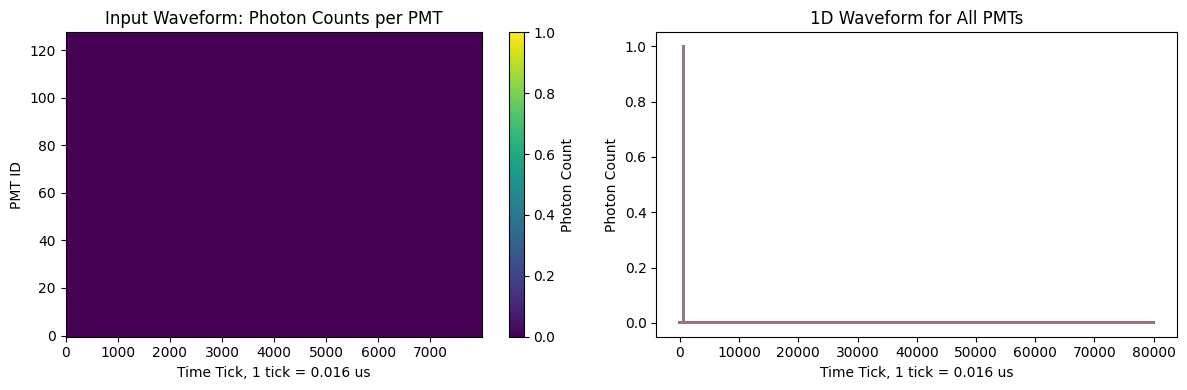

In [4]:
pmt_ids = torch.arange(128)
arrival_times = torch.zeros(128, dtype=torch.int64) + 500
wf = sim.gen_waveform(mode='precise', pmt_ids=pmt_ids, arrival_times=arrival_times)

# Downsampling to match future output resolution from
downsampled_wf = sim.downsample_waveform(wf.unsqueeze(0))
print(f"Waveform shape: {wf.shape}")

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))  # 1 row, 2 columns

# Left plot: 2D waveform image from downsampled_wf
im = ax1.imshow(downsampled_wf.squeeze(0), aspect='auto', origin='lower')
ax1.set_xlabel(f"Time Tick, 1 tick = {sim.light_tick_size * 16} us")
ax1.set_ylabel("PMT ID")
ax1.set_title("Input Waveform: Photon Counts per PMT")
cbar = fig.colorbar(im, ax=ax1)
cbar.set_label("Photon Count")

# Right plot: 1D waveform lines from wf
n_pmts, n_ticks = wf.shape
ticks = np.arange(n_ticks)
for i in range(n_pmts):
    ax2.plot(ticks, wf[i], alpha=0.5)
ax2.set_xlabel(f"Time Tick, 1 tick = {sim.light_tick_size * 16} us")
ax2.set_ylabel("Photon Count")
ax2.set_title("1D Waveform for All PMTs")

plt.tight_layout()
plt.show()

#### Gaussian Mode: Randomly sampling arrival times for `n_photons` photons in each (`pmt_id`, `n_photons`) pair

Waveform shape: torch.Size([128, 80000])


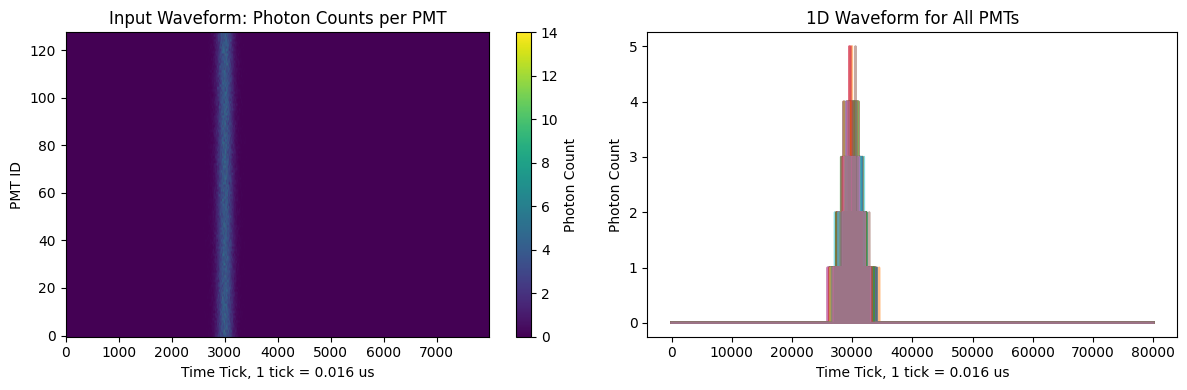

In [5]:
# Adding an offset to simulated waveforms to better see gaussian shape
params = dict()
params['offset'] = 3000 #ns
sim.reconfigure(params)

pmt_ids = torch.arange(128)
n_photons = np.full_like(pmt_ids, 1000)

wf = sim.gen_waveform(mode='gaussian', pmt_ids=pmt_ids, nphotons=n_photons)
downsampled_wf = sim.downsample_waveform(wf.unsqueeze(0))

print(f"Waveform shape: {wf.shape}")

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))  # 1 row, 2 columns

# Left plot: 2D waveform image from downsampled_wf
im = ax1.imshow(downsampled_wf.squeeze(0), aspect='auto', origin='lower')
ax1.set_xlabel(f"Time Tick, 1 tick = {sim.light_tick_size * 16} us")
ax1.set_ylabel("PMT ID")
ax1.set_title("Input Waveform: Photon Counts per PMT")
cbar = fig.colorbar(im, ax=ax1)
cbar.set_label("Photon Count")

# Right plot: 1D waveform lines from wf
n_pmts, n_ticks = wf.shape
ticks = np.arange(n_ticks)

for i in range(n_pmts):
    ax2.plot(ticks, wf[i], alpha=0.5)
ax2.set_xlabel(f"Time Tick, 1 tick = {sim.light_tick_size * sim.downsampling_factor} us")
ax2.set_ylabel("Photon Count")
ax2.set_title("1D Waveform for All PMTs")

plt.tight_layout()
plt.show()

### Visualizing One Photon WF as a Sanity Check
* Time to peak should be on the order of a few nanoseconds
* Time for rising edge to return to baseline should be on the order of tens of nanoseconds

The electronics response convolution (in `make_waveform.py`, but from larnd-sim) accounts for variability in the signal amplification process done by PMTs. So, the amplitude of a single photon signal has some randomness.

In [6]:
params = dict()
params['light_tick_size'] = 0.001 # 100 picoseconds in microseconds units
params['downsample_factor'] = 10
params['tpb_tau'] = 0.002
params['offset'] = 10
sim.reconfigure(params)
print(sim.offset)

100


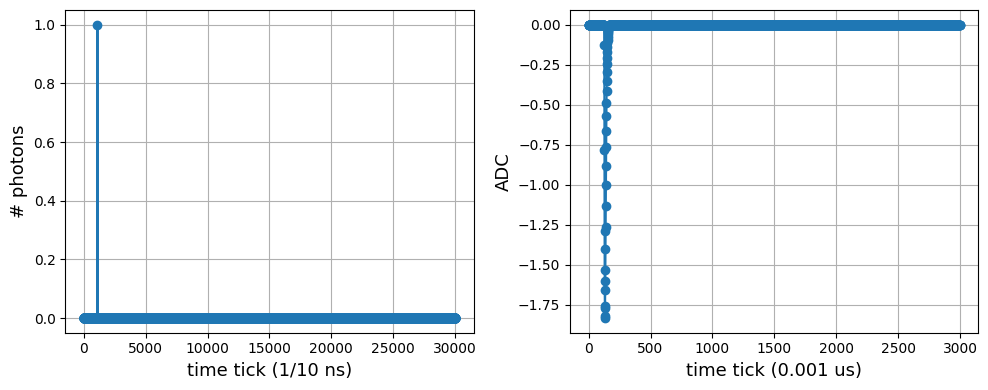

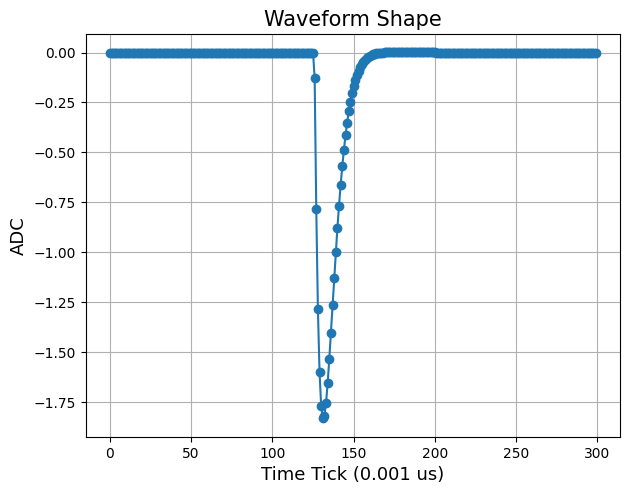

In [8]:
# Generating Waveform
nphotons = 1
pmt_ids = torch.zeros(nphotons, dtype=torch.int64)
arrival_times = torch.zeros(nphotons, dtype=torch.int64) + 1000 # in units of 1/10 ns
wf = sim.gen_waveform(mode='precise', pmt_ids=pmt_ids, arrival_times=arrival_times, n_pmts=1)

# Electronics Convolution
output, _ = sim(wf.to(device), scintillation=False, tpb_delay=False, combined=True)
output = output.detach().cpu().numpy()

fig, axes = plt.subplots(1, 2, figsize=(10, 4))  # 1 row, 2 columns

# First plot
axes[0].plot(wf[0][:30000], marker = 'o')
axes[0].set_ylabel("# photons", fontsize=13)
axes[0].set_xlabel("time tick (1/10 ns)", fontsize=13)
axes[0].grid(True)

axes[1].plot(output[:3000], marker='o')
axes[1].grid(True)
axes[1].set_xlabel(f"time tick ({sim.light_tick_size} us)", fontsize=13)
axes[1].set_ylabel("ADC", fontsize=13)

plt.tight_layout()
plt.show()

# Second plot - zoomed in
plt.plot(output[:300], marker='o')
plt.grid(True)
plt.xlabel(f"Time Tick ({sim.light_tick_size} us)", fontsize=13)
plt.ylabel("ADC", fontsize=13)
plt.tight_layout()
plt.title("Waveform Shape", fontsize=15)
plt.show()